<img align="center" style="max-width: 1000px" src="../assets/banner.png">

<img align="right" style="max-width: 200px; height: auto" src="figures/hsg_logo.png">

##  Lab 09 - Transfer Learning and Self-supervised Learning (SSL)

Machine Learning, University of St. Gallen, Autumn Term 2025

# Lab Objectives
After today's lab, you should be able to:

1. Understand the basic concepts and intuition of **transfer learning** and **self-supervised learning**.
2. Know how to **load and fine-tune** pre-trained pytorch models.
3. Understand how self-supervised learning uses **pre-text tasks** to create a learning signal.
4. Know how to **train** self-supervised models.

## Problem
How can we train a deep learning model with millions of parameters on a small dataset?

For example, PASCAL VOC:

<img align="center" style="max-width: 900px" src="figures/transfer-pascal-voc.png">

## The transfer learning idea
* Train a model on a large, similar dataset
* Use that model as *smart initialization* for training on the target dataset

<img align="center" style="max-width: 900px" src="figures/transfer-setup.png">

In this lab, we will use a model pre-trained on the ImageNet dataset and apply it on PASCAL VOC

# Pre-training
Following common practice, we will not pre-train the model on our own. This is time and compute-intensive, and many capable models can be found online.

PyTorch has a `torch.hub` platform where trained models are hosted. You can conveniently download the weights from the hub when instantiating a `torchvision` model directly in python.
Note that the weights will be downladed to a cache, which can be set via the `TORCH_HOME` environment variable.

In [1]:
# via https://pytorch.org/vision/stable/models.html
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL
import torch
import torchvision
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image

plt.rcParams.update({'font.size': 15})

In [2]:
# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [3]:
# No weights - random initialization
random_model = resnet50(weights=None)

In [4]:
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
    
torch.save({"state_dict": model.state_dict()}, "checkpoints/resnet50_checkpoint.pth")

## Let's compare the pre-trained model with a newly initialized model

In [5]:
def get_weight_grid(model, layername="conv1"):
    layer = getattr(model, layername)
    # Get the weights of the first layer
    weights = layer.weight.data.cpu()
    # Create a grid of images from the weights
    grid = torchvision.utils.make_grid(weights, normalize=True)
    
    return grid

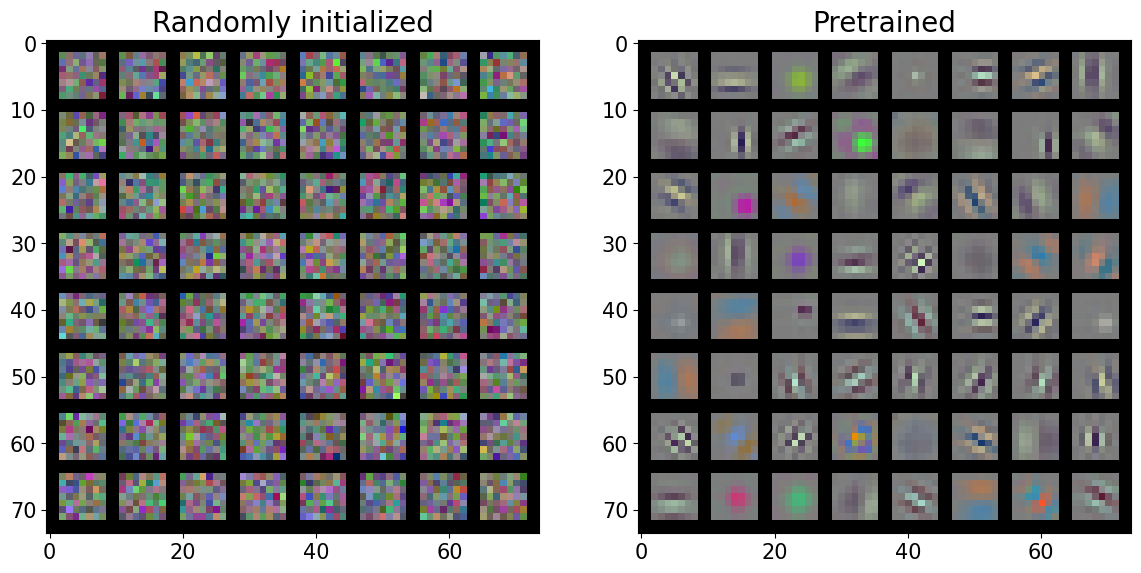

In [6]:
fig, axs = plt.subplots(1,2, figsize=(14,7))
# Visualize the grid
axs[0].imshow(get_weight_grid(random_model).permute(1, 2, 0))
axs[0].set_title("Randomly initialized", fontsize=20)
axs[1].imshow(get_weight_grid(model).permute(1, 2, 0))
axs[1].set_title("Pretrained", fontsize=20)
plt.show()

# Loading a model checkpoint from disc
You can also load weights from other sources than `torch.hub` into pytorch models.

Here, weights for a ResNet50 model are saved within the repository as `checkpoint.pth´.

In [7]:
# load checkpoint from disc
checkpoint = torch.load("checkpoints/resnet50_checkpoint.pth")
checkpoint.keys()

dict_keys(['state_dict'])

In [8]:
# inspect the content of the state dict
for i, (k,v) in enumerate(checkpoint["state_dict"].items()):
    print(k, v.shape)
    if i == 5: break
print("...")

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
bn1.running_mean torch.Size([64])
bn1.running_var torch.Size([64])
bn1.num_batches_tracked torch.Size([])
...


In [9]:
# load weights into the model
random_model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

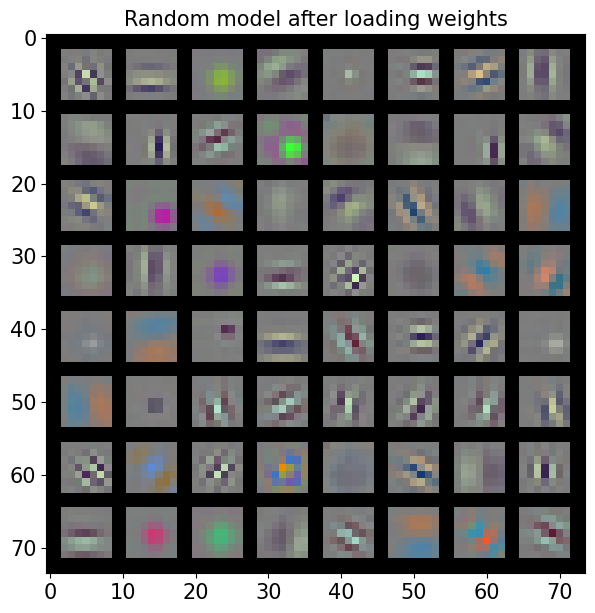

In [10]:
fig, ax = plt.subplots(1, figsize=(7,7))
ax.imshow(get_weight_grid(random_model).permute(1, 2, 0))
ax.set_title("Random model after loading weights", fontsize=15)
plt.show()

## Common errors
The **weight keys need to match the attribute names** in the model, note this error message:

In [11]:
# re-name one weight to illustrate the error
checkpoint["state_dict"]["new.conv1.weight"] = checkpoint["state_dict"].pop("conv1.weight")

In [12]:
# load weights into the model
random_model.load_state_dict(checkpoint["state_dict"])

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight". 
	Unexpected key(s) in state_dict: "new.conv1.weight". 

In [13]:
# we can force the model to load all matching weights, anyway
missing, unexpected = random_model.load_state_dict(checkpoint["state_dict"], strict=False)
f"{missing=}, {unexpected=}"

"missing=['conv1.weight'], unexpected=['new.conv1.weight']"

This loads all matching weights and returns the names of the missing weights as well as those that didn't match any model fields.
It commonly happens that pre-trained models contain additional layers that we don't want to load for our downstream task.

## Pre-processing
* When using pre-trained models, we want to use the same pre-processing in our pipeline as the original model used
* PyTorch makes this easy for the built-in weights

In [14]:
to_tensor = torchvision.transforms.ToTensor()

in_paths = glob.glob(os.path.join("sample_data/imagenet", "*.JPEG"))
# in_imgs = [torchvision.io.read_image(f) for f in in_paths]
in_imgs = [to_tensor(PIL.Image.open(image_path)) for image_path in in_paths]

In [15]:
# Initialize the Weight Transforms
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [16]:
# Apply the transformation to the sample images
in_imgs_transformed = torch.stack([preprocess(img) for img in in_imgs])
in_imgs_transformed.shape

torch.Size([5, 3, 224, 224])

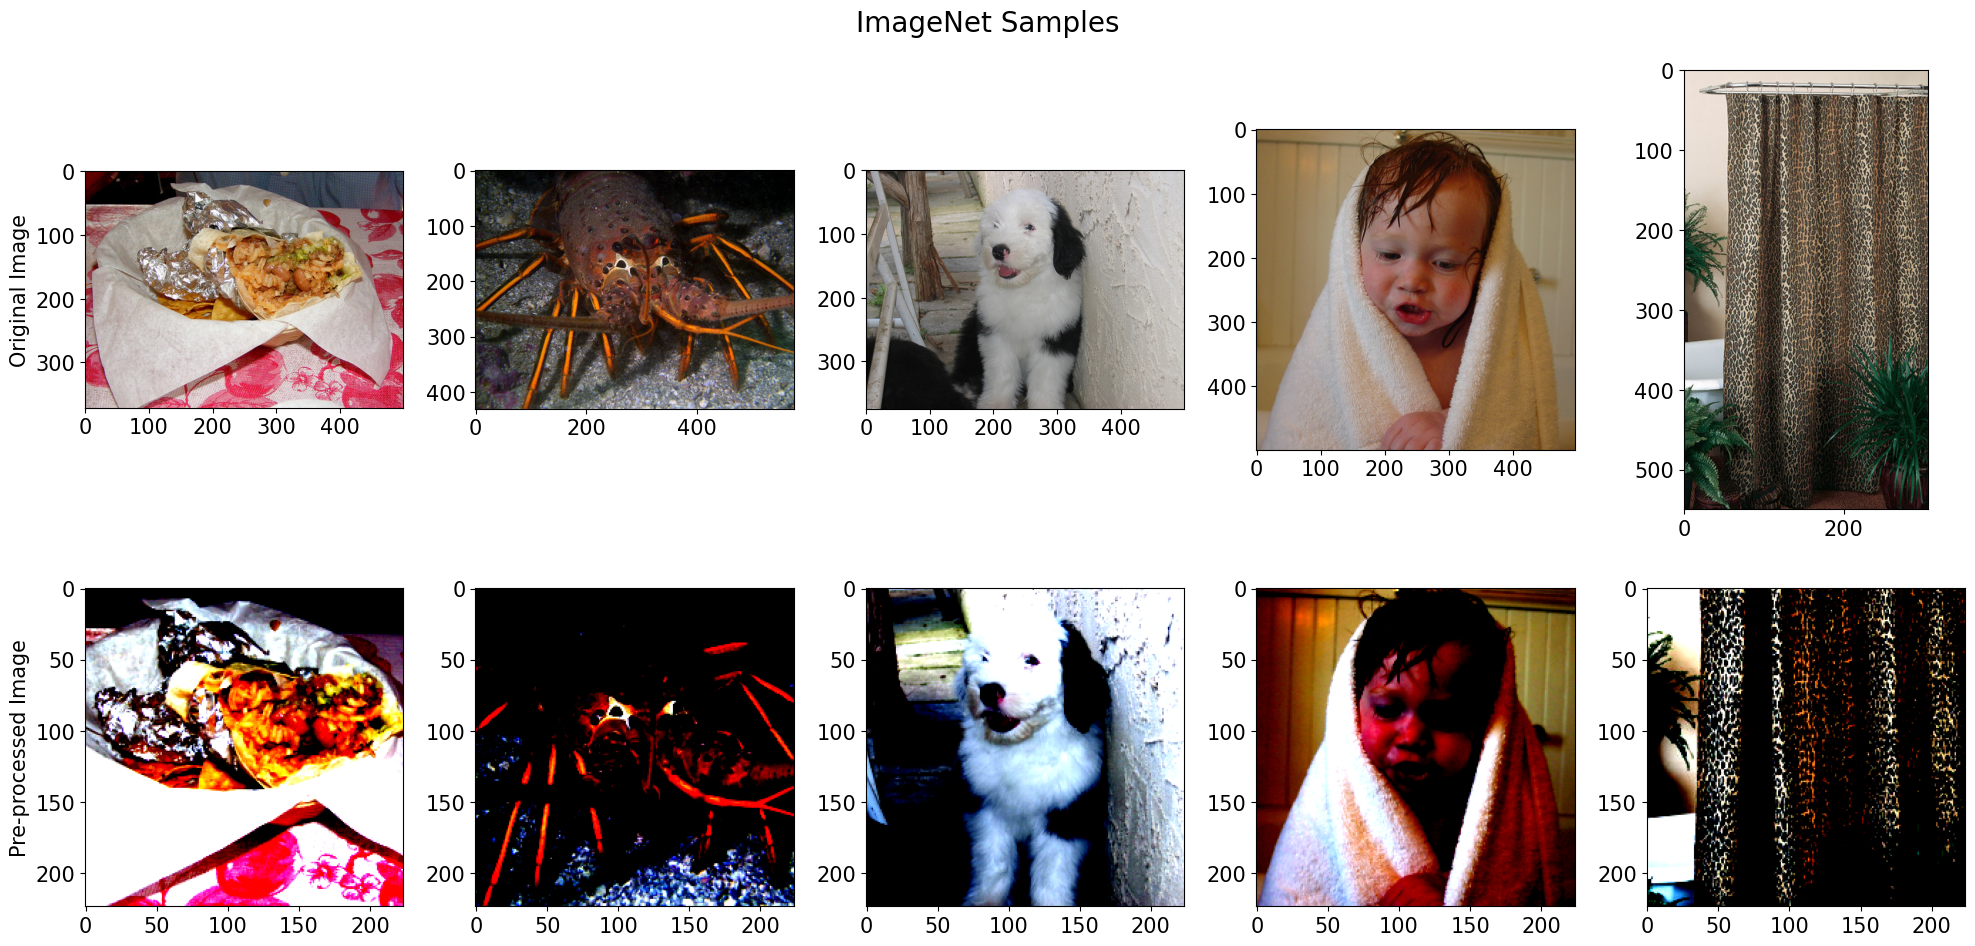

In [17]:
fig, axs = plt.subplots(2, 5, figsize=(20,10))
for col, (img, img_t) in enumerate(zip(in_imgs, in_imgs_transformed)):
    
    axs[0, col].imshow(torch.moveaxis(img, 0, -1))
    axs[1, col].imshow(torch.moveaxis(torch.clip(img_t, 0,1), 0, -1))
axs[0,0].set_ylabel("Original Image", fontsize=15)
axs[1,0].set_ylabel("Pre-processed Image", fontsize=15)
plt.suptitle("ImageNet Samples", fontsize=20)
plt.tight_layout()
plt.show()

## Pre-processing standardizes Images

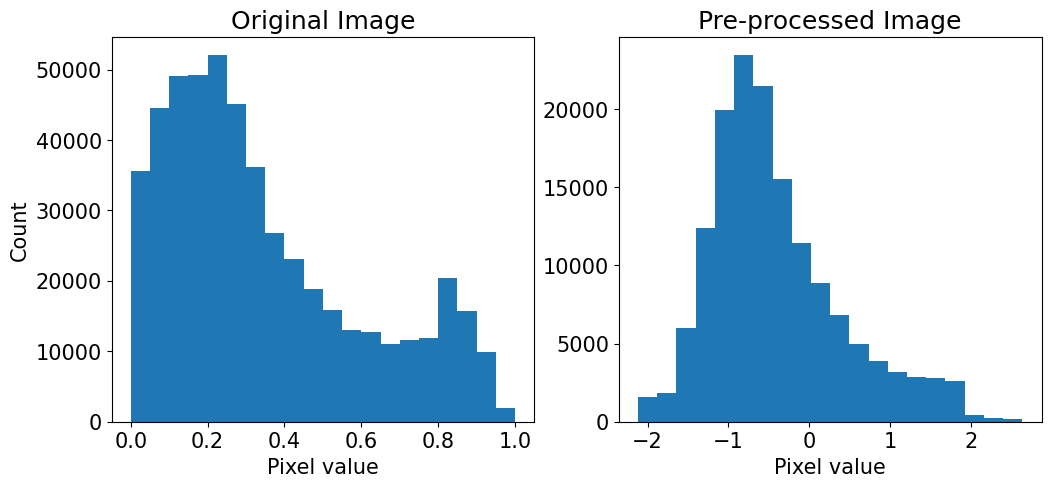

In [18]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].hist(img.flatten(), bins=20)
axs[0].set_title("Original Image")
axs[0].set_ylabel("Count")
axs[0].set_xlabel("Pixel value")
axs[1].hist(img_t.flatten(), bins=20)
axs[1].set_title("Pre-processed Image")
axs[1].set_xlabel("Pixel value")
plt.show()

# Predictions from the pre-trained Model

In [19]:
# load label mapping from file
imagenet_class_idx = json.load(open("sample_data/imagenet/imagenet_class_index.json"))
imagenet_class_names = {}
for name, label in imagenet_class_idx.values():
    imagenet_class_names[name] = label

In [20]:
# set model to evaluation mode
model.eval()

# get predictions and map to [0,1] with sigmoid
y_hat = torch.sigmoid(model(in_imgs_transformed))

In [21]:
# extract index of most likely class
_, predictions = y_hat.max(axis=1)
predictions

tensor([965, 123, 229, 434, 794])

In [22]:
# get string labels for class indices
predicted_labels = [imagenet_class_idx[str(pred.item())][1] for pred in predictions]
print(f"Predicted labels:\n{predicted_labels}")

Predicted labels:
['burrito', 'spiny_lobster', 'Old_English_sheepdog', 'bath_towel', 'shower_curtain']


In [23]:
# get the true labels for each sample image
in_ids = [f.split("/")[-1].split("_")[0] for f in in_paths]
true_labels = [imagenet_class_names[id] for id in in_ids]
print(f"True labels:\n{true_labels}")

True labels:
['burrito', 'spiny_lobster', 'Old_English_sheepdog', 'bath_towel', 'shower_curtain']


### What are the top predictions?
* Let's look at the last sample image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6372285].


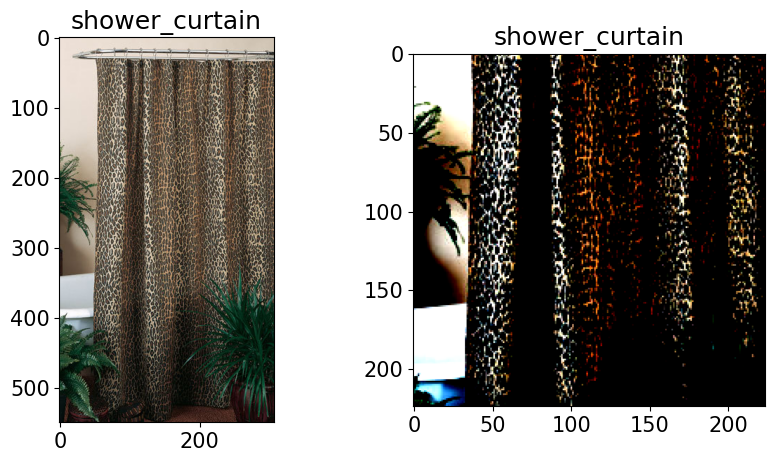

In [24]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(torch.moveaxis(in_imgs[-1], 0, -1))
axs[1].imshow(torch.moveaxis(in_imgs_transformed[-1], 0, -1))
axs[0].set_title(true_labels[-1])
axs[1].set_title(predicted_labels[-1])
plt.show()

In [25]:
# extract top-5 class indices based on logits
top_logits, top_predictions = y_hat[-1].topk(k=5)
for idx, (pred, logit) in enumerate(zip(top_predictions, top_logits)):
    print(f"{idx+1}. {imagenet_class_idx[str(pred.item())][1]} ({logit.item():.3f})") 

1. shower_curtain (0.999)
2. window_shade (0.967)
3. window_screen (0.959)
4. lampshade (0.945)
5. tub (0.907)


# Transfer to PascalVOC

<img align="center" style="max-width: 900px" src="figures/transfer-setup.png">

In [26]:
# read pascal voc sample images
voc_paths = glob.glob(os.path.join("sample_data/voc", "*.jpg"))
# voc_imgs = [read_image(f) for f in voc_paths]
voc_imgs = [to_tensor(PIL.Image.open(f)) for f in voc_paths]
voc_imgs_transformed = torch.stack([preprocess(img) for img in voc_imgs])
voc_imgs_transformed.shape

torch.Size([5, 3, 224, 224])

In [27]:
# get labels for pascal voc samples
with open("sample_data/voc/labels.csv", "r") as f:
    voc_labels = {x.split(",")[0] : x.strip().split(",")[1] for x in f.readlines()}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.113081..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0285332..0.9846448].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0589795..2.640001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6902888..2.634716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0987432..2.6375315].


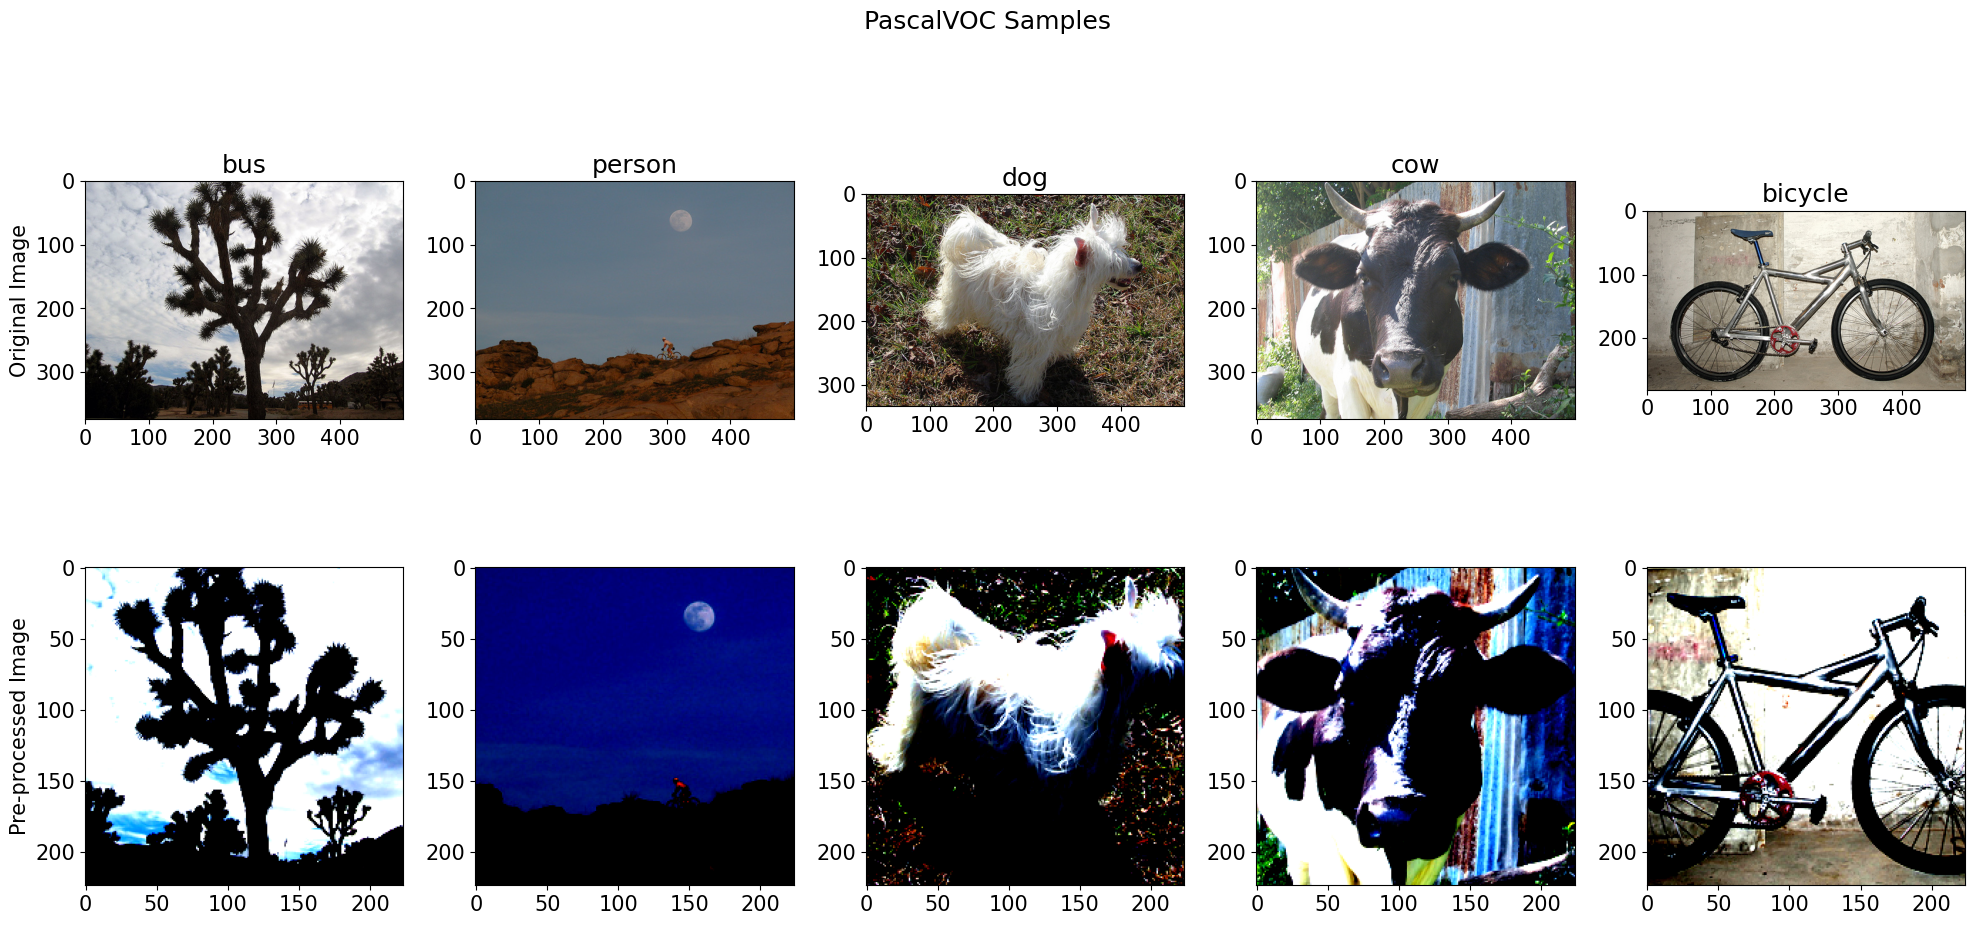

In [28]:
fig, axs = plt.subplots(2, 5, figsize=(20,10))
for col, (img, img_t, img_path) in enumerate(zip(voc_imgs, voc_imgs_transformed, voc_paths)):
    label = voc_labels.get(img_path.split("/")[-1].split(".")[0])
    axs[0, col].imshow(torch.moveaxis(img, 0, -1))
    axs[0, col].set_title(label)
    axs[1, col].imshow(torch.moveaxis(img_t, 0, -1))
    #axs[1, col].set_title(predicted_labels[col])
axs[0,0].set_ylabel("Original Image")
axs[1,0].set_ylabel("Pre-processed Image")
plt.suptitle("PascalVOC Samples")
plt.tight_layout()
plt.show()

In [29]:
# predict imagenet labels for pascal voc samples
model.eval()

y_hat = model(voc_imgs_transformed)
_, predictions = y_hat.max(axis=1)
predicted_labels = [imagenet_class_idx[str(pred.item())][1] for pred in predictions]
predicted_labels

['seashore', 'bighorn', 'West_Highland_white_terrier', 'ox', 'mountain_bike']

# Adjust and fine-tune the model
* ImageNet has 1000 classes
* Classification problem with 20 **multi-label classes**
* I.e., each image can contain more than one object

In [30]:
# adjust output layer
print(f"Old output layer: {model.fc}")
model.fc = torch.nn.Linear(in_features=2048, out_features=20)
print(f"New output layer: {model.fc}")

Old output layer: Linear(in_features=2048, out_features=1000, bias=True)
New output layer: Linear(in_features=2048, out_features=20, bias=True)


In [31]:
finetune = False

In [32]:
# reduce memory requirements when only training final layer

if not finetune:
    for name, param in model.named_parameters():
        if "fc" not in name:
            param.requires_grad = False
        
model.conv1.weight.requires_grad, model.fc.weight.requires_grad, 

(False, True)

In [33]:
# create optimizer with different learning rates for the random classification layer and the pre-trained backbone
if finetune:
    optimizer = torch.optim.Adam([
                {'params': [p for n,p in model.named_parameters() if not "fc" in n], 'lr': 0.01},
                {'params': model.fc.parameters(), 'lr': 0.1}
            ])
else:
    optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.1,)

In [34]:
criterion = torch.nn.BCEWithLogitsLoss()

In [35]:
# transform pascal voc target dict to multi-one hot targets
class VOCTargetTransform(object):
    def __init__(self):
        super().__init__()
        self.labels = np.array(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
                     'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
                     'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor',])
        self.voc_class_index = {name : idx for idx, name in enumerate(self.labels)}
        
    def __call__(self, y):
        objects = list(set([obj["name"] for obj in y["annotation"]["object"]]))
        label = torch.zeros(len(self.labels))
        for obj in objects:
            label[self.voc_class_index[obj]] = 1
        return label
    
    def one_hot_to_labels(self, one_hot_label):
        return self.labels[one_hot_label.bool()].tolist()

In [36]:
t_transform = VOCTargetTransform()
dataset = torchvision.datasets.VOCDetection("data", download=False, transform=preprocess, target_transform=t_transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, num_workers=4, shuffle=True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [37]:
losses = []

In [38]:
model.to(device)
model.train()

for epoch in range(10):
    batch_losses = []
    for img, label in tqdm(loader, leave=False):
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        y_hat = model(img)
        loss = criterion(y_hat, label)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        
    print(f"Epoch: {epoch}, loss: {np.array(losses)[-len(loader):].mean():.3f}")

  0%|                                                                                                                                                                                          | 0/90 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/lmeynent/miniconda3/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lmeynent/miniconda3/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'VOCTargetTransform' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
                                                                                                                                                                                                                     

KeyboardInterrupt: 

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

In [ ]:
# forward pass for each sample image
model.eval()

y_hat = torch.sigmoid(model(voc_imgs_transformed.to(device)))

In [ ]:
# get the most likely class (according to the model) for each sample image
_, predictions = y_hat.max(axis=1)
predicted_labels = [t_transform.labels[pred] for pred in predictions]
predicted_labels

In [ ]:
# let's look at the top predictinos for each image
logits, class_idxs = y_hat.topk(k=3, dim=1)

for img_logits, img_class_idx, in zip(*y_hat.topk(k=3, dim=1)):
    print(", ".join([f"{c}: {p:.3f}" for c,p in zip(t_transform.labels[img_class_idx.detach().cpu()], img_logits.detach().cpu().tolist())]))
#[t_transform.one_hot_to_labels(y.detach().cpu()) for y in y_hat > 0.2]

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(15, 7.5))
for col, (img, img_t, img_path) in enumerate(zip(voc_imgs, voc_imgs_transformed, voc_paths)):
    label = voc_labels.get(img_path.split("/")[-1].split(".")[0])
    axs[0, col].imshow(torch.moveaxis(img, 0, -1))
    axs[0, col].set_title(label)
    axs[1, col].imshow(torch.moveaxis(img_t, 0, -1))
    axs[1, col].set_title(predicted_labels[col])
axs[0,0].set_ylabel("Original Image")
axs[1,0].set_ylabel("Pre-processed with top Prediction")
plt.suptitle("PascalVOC Samples")
plt.tight_layout()
plt.show()

# Self-supervised Learning

<img align="center" style="max-width: 600px" src="figures/ssl-goal.png">

We want to use data to create its own supervision label for a **pretext-task**.

This can be:
* **Reconstruction** from corruption: noise, inpainting, colorization
* **Common sense** tasks: relative patch prediction, jigsaw puzzle, rotation


# Rotation Prediction
<img align="center" style="max-width: 900px" src="figures/rotation-prediction.png">

In [39]:
# we use a smaller resnet18 model for this task
# the classifier is adjusted for 4 outputs, corresponding to 0,90,180,270 degree rotations
model = torchvision.models.resnet18(weights=None)
model.fc = torch.nn.Linear(512, 4, bias=True)

In [40]:
# We modify the built-in torchvision datasets to get the rotated images + targets directly
class RotationPredictionVOC(torchvision.datasets.VOCDetection):
    def __init__(self, root, **kwargs):
        super().__init__(root, **kwargs)
        
    def __getitem__(self, index: int):
        img = Image.open(self.images[index]).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)
            
        img90 = torch.flip(img.transpose(1,2), (2,)).unsqueeze(0)
        img180 = torch.flip(img, (1,2)).unsqueeze(0)
        img270 = torch.flip(img, (1,)).transpose(1,2).unsqueeze(0)
        imgs = torch.cat((img.unsqueeze(0), img90, img180, img270), dim=0).contiguous()
        targets = torch.arange(4).long()

        return imgs, targets
    
class RotationPredictionCifar10(torchvision.datasets.CIFAR10):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def __getitem__(self, index: int):
            img, target = self.data[index], self.targets[index]
            img = Image.fromarray(img)

            if self.transform is not None:
                img = self.transform(img)
        
            img90 = torch.flip(img.transpose(1,2), (2,)).unsqueeze(0)
            img180 = torch.flip(img, (1,2)).unsqueeze(0)
            img270 = torch.flip(img, (1,)).transpose(1,2).unsqueeze(0)
            imgs = torch.cat((img.unsqueeze(0), img90, img180, img270), dim=0).contiguous()
            targets = torch.arange(4).long()

            return imgs, targets

In [42]:
# we use cifar10 to illustrate rotation prediction pre-training
cifar_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = RotationPredictionCifar10(root="data", download=True, transform=cifar_transform)
#dataset = RotationPredictionVOC("/ds2/computer_vision/pascal_voc_2012", download=False, transform=preprocess)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:14<00:00, 12.1MB/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.99215686].
Clipping input data to the val

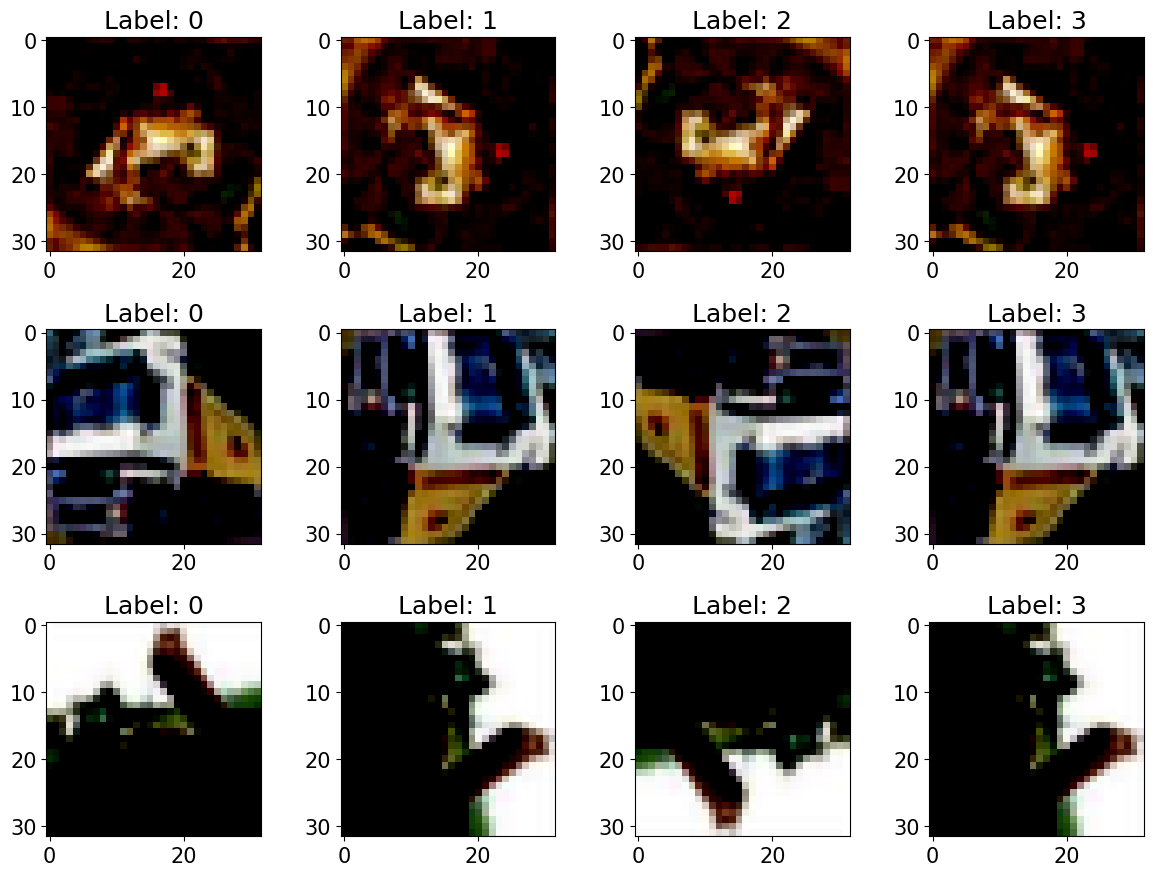

In [43]:
fig, axs = plt.subplots(3, 4, figsize=(12,9))

for row in range(3):
    x,y = dataset[row]
    for col in range(4):
        axs[row, col].imshow(torch.moveaxis(x[col], 0, -1))
        axs[row, col].set_title(f"Label: {y[col]}")
        
plt.tight_layout()
plt.show()

In [44]:
# standard torchvision dataloaders expect to get one image and one target from __getitem__ of the dataset
# we need a custom collate function to deal with the 4 rotations our dataset returns
def collate(args):
    imgs, labels = zip(*args)
    return torch.concat(imgs, dim=0), torch.concat(labels, dim=0)

loader = torch.utils.data.DataLoader(dataset, batch_size=64, num_workers=4, collate_fn=collate, shuffle=True)

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

In [46]:
losses = []
accuracy = []

In [47]:
model.to(device)
model.train()

for epoch in range(10):
    epoch_acc = []
    for imgs, labels in tqdm(loader, leave=False):
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, labels)
        loss.backward()
        optimizer.step()

        _, pred = y_hat.max(dim=1)
        losses.append(loss.item())
        batch_acc = (pred == labels).to(float).mean().item()
        accuracy.append(batch_acc)
        epoch_acc.append(batch_acc)
        
    print(f"Epoch {epoch}, accuracy: {np.array(epoch_acc).mean():.3f}")

  0%|                                                                                                                                                                                         | 0/782 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/lmeynent/miniconda3/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lmeynent/miniconda3/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'RotationPredictionCifar10' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
                                                                                                                                                                                                              

KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].plot(losses)
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[1].plot(accuracy)
axs[1].axhline(y=0.25, color='r', linestyle='--')
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Accuracy")
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(14,7))
# Visualize the grid
axs[0].imshow(get_weight_grid(torchvision.models.resnet18(weights=None)).permute(1, 2, 0))
axs[0].set_title("Randomly initialized")
axs[1].imshow(get_weight_grid(model).permute(1, 2, 0))
axs[1].set_title("Rotation prediction")
plt.show()

## Transfer to downstream task
* Replace and then fine-tune the classification layer

In [48]:
# standard cifar 10
dataset = torchvision.datasets.CIFAR10(root="data", transform=cifar_transform)
test_dataset = torchvision.datasets.CIFAR10(root="data", transform=cifar_transform, train=False)

# dataloaders
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, num_workers=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=4)

# cifar10 output layer
model.fc = torch.nn.Linear(512, 10)

optimizer = torch.optim.SGD(model.fc.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

In [49]:
for name, param in model.named_parameters():
    if not "fc" in name:
        param.requires_grad = False

In [50]:
# baseline model with random initialization

if False:
    model = torchvision.models.resnet18()
    model.fc = torch.nn.Linear(512, 10)
    optimize = torch.optim.SGD(model.fc.parameters(), lr=3e-4)

    for name, param in model.named_parameters():
        if not "fc" in name:
            param.requires_grad = False

In [51]:
losses = []
accuracy = []

In [ ]:
model.to(device)
model.train()

epochs = 10

for epoch in range(epochs):
    epoch_acc = []
    for imgs, labels in tqdm(train_loader, leave=False):
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, labels)
        loss.backward()
        optimizer.step()

        _, pred = y_hat.max(dim=1)
        losses.append(loss.item())
        batch_acc = (pred == labels).to(float).mean().item()
        accuracy.append(batch_acc)
        epoch_acc.append(batch_acc)
        
    print(f"Epoch {epoch}, accuracy: {np.array(epoch_acc).mean():.3f}")

Epoch 0, accuracy: 0.122


Epoch 1, accuracy: 0.161


Epoch 2, accuracy: 0.186


Epoch 3, accuracy: 0.203


Epoch 4, accuracy: 0.220


Epoch 5, accuracy: 0.229


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 352/782 [01:10<01:17,  5.55it/s]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].plot(losses)
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[1].plot(accuracy)
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Accuracy")
plt.tight_layout()
plt.show()

In [ ]:
# Evaluation

val_losses = []
val_accs = []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, leave=False):
        imgs = imgs.to(device)
        labels = labels.to(device)

        y_hat = model(imgs)
        loss = criterion(y_hat, labels)

        _, pred = y_hat.max(dim=1)
        val_losses.append(loss.item())
        batch_acc = (pred == labels).to(float).mean().item()
        val_accs.append(batch_acc)
        
print(f"Validation accuracy: {np.array(val_accs).mean():.3f}, loss: {np.array(val_losses).mean():.3f}")

# Inpainting with Context Encoders
<img align="center" style="max-width: 1200px" src="figures/context-encoder.png">

In [ ]:
class ChannelwiseFullyConnected(torch.nn.Module):
    def __init__(self, num_channels, map_size):
        super().__init__()
        self.num_channels = num_channels
        self.map_size = map_size
        self.fcs = [torch.nn.Linear(map_size, map_size) for _ in range(self.num_channels)]
        
    def forward(self, x):
        assert x.shape[1] == self.num_channels
        assert x.shape[2] * x.shape[3] == self.map_size
        
        return torch.stack([self.fcs[idx](x[:,idx]) for idx in range(self.num_channels)], dim=1)

In [ ]:
class ContextEncoder(torch.nn.Module):
    # encoder-decoder adapted from https://github.com/rll/deepul/blob/master/demos/lecture7_selfsupervised_demos.ipynb
    def __init__(self):
        super().__init__()
        self.latent_dim = 512
        self.encoder = torch.nn.Sequential(
            # 128 x 128 Input
            torch.nn.Conv2d(3, 64, 4, stride=2, padding=1), # 64 x 64
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(64, 64, 4, stride=2, padding=1), # 32 x 32
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(64, 128, 4, stride=2, padding=1), # 16 x 16
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(128, 256, 4, stride=2, padding=1), # 8 x 8
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(256, 512, 4, stride=2, padding=1), # 4 x 4
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(512, self.latent_dim, 4) # 1 x 1
        )
        
        self.bottleneck = ChannelwiseFullyConnected(self.latent_dim, 1)
        
        self.decoder = torch.nn.Sequential(
            torch.nn.BatchNorm2d(self.latent_dim),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(self.latent_dim, 512, 4, stride=1, padding=0),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            torch.nn.Tanh()
        )
        
    def mask_center(self, x):
        assert x.shape[-1] == x.shape[-2], f"Image not square: {x.shape}"
        width = x.shape[-1]
        
        center = x[:, :, width//4 : width//4+width//2, width//4 : width//4+width//2].clone()
        
        masked = x.clone()
        masked[:, :, width//4 : width//4+width//2, width//4 : width//4+width//2] = 0
        
        return center, masked
    
    def forward(self, x):
        center, masked = self.mask_center(x)
        z = self.encoder(masked)
        
        recon = self.decoder(z)
        
        return center, recon

In [ ]:
model = ContextEncoder()
model.to(device)
model.train()
f"{sum([p.numel() for p in model.parameters()]):,} parameters"

In [ ]:
transform = torchvision.transforms._presets.ImageClassification(crop_size=128, resize_size=132, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)

In [ ]:
t_transform = VOCTargetTransform()
dataset = torchvision.datasets.VOCDetection("data", download=False, transform=transform, target_transform=t_transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, num_workers=4, shuffle=True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

In [ ]:
losses = []

In [ ]:
for epoch in range(25):
    for imgs, labels in tqdm(loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        center, recon = model(imgs)

        loss = criterion(recon, center)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    print(f"Epoch: {epoch}, loss: {np.array(losses)[-len(loader):].mean():.3f}")

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

In [ ]:
# mask and re-create some samples

model.eval()

with torch.no_grad():
    voc_imgs_128 = torch.stack([transform(x) for x in voc_imgs])
    _, voc_masked = model.mask_center(voc_imgs_128)
    voc_center, voc_recon = model(voc_imgs_128.to(device))

    voc_combined = voc_masked.clone()
    width = voc_imgs_128.shape[-1]
    voc_combined[:, :, width//4 : width//4+width//2, width//4 : width//4+width//2] = voc_recon.detach()

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(15, 9))

for col in range(5):
    axs[0, col].imshow(torch.moveaxis(voc_imgs_128[col].cpu(), 0, -1))
    axs[1, col].imshow(torch.moveaxis(voc_masked[col].cpu(), 0, -1))
    axs[2, col].imshow(torch.moveaxis(voc_combined[col].detach().cpu(), 0, -1))

axs[0,0].set_ylabel("Target Image")
axs[1,0].set_ylabel("Masked input Image")
axs[2,0].set_ylabel("Inpainted Image")
plt.tight_layout()
plt.show()

If we keep training, the model will learn to estimate the masked portions of the image better and better. The paper proposes an additional **adversarial loss** to produce more realistic inpaintings.

In [ ]:
# save checkpoint
# torch.save({"state_dict" : model.state_dict(), "losses" : losses}, "checkpoints/context_encoder.pth")

In [ ]:
# load saved checkpoint
checkpoint = torch.load("checkpoints/context_encoder.pth")
losses = checkpoint["losses"]
model.load_state_dict(checkpoint["state_dict"])

# Pre-trained Self-supervised Models

Similar to the transfer learning example above, the SSL pre-trained models can now be adjusted for our target downstream task.

Note that `torchvision` also provides self-supervised pre-trained weights for some models.

In [ ]:
resnet50 = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(14,7))
# Visualize the grid
axs[0].imshow(get_weight_grid(torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)).permute(1, 2, 0))
axs[0].set_title("ImageNet pretrained")
axs[1].imshow(get_weight_grid(resnet50).permute(1, 2, 0))
axs[1].set_title("Self-supervised pretrained (DINO)")
plt.show()

## Transfer to downstream task
* downstream task (pascal voc) comparison: supervised vs ssl
* Self-supervised models can be used on downstream tasks in the same transfer learning setup shown above

In [ ]:
# adjust output layer
print(f"Old output layer: {resnet50.fc}")
resnet50.fc = torch.nn.Linear(in_features=2048, out_features=20)
print(f"New output layer: {resnet50.fc}")

In [ ]:
finetune = False
# reduce memory requirements when only training final layer

if not finetune:
    for name, param in resnet50.named_parameters():
        if "fc" not in name:
            param.requires_grad = False
        
resnet50.conv1.weight.requires_grad, resnet50.fc.weight.requires_grad, 

In [ ]:
# create optimizer with different learning rates for the random classification layer and the pre-trained backbone
if finetune:
    optimizer = torch.optim.Adam([
                {'params': [p for n,p in resnet50.named_parameters() if not "fc" in n], 'lr': 0.01},
                {'params': resnet50.fc.parameters(), 'lr': 0.1}
            ])
else:
    optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=0.1,)

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
t_transform = VOCTargetTransform()
dataset = torchvision.datasets.VOCDetection("/ds2/computer_vision/pascal_voc_2012", download=False, transform=preprocess, target_transform=t_transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, num_workers=4, shuffle=True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

In [ ]:
losses = []

In [ ]:
resnet50.to(device)
resnet50.train()

for epoch in range(10):
    batch_losses = []
    for img, label in tqdm(loader, leave=False):
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        y_hat = resnet50(img)
        loss = criterion(y_hat, label)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        
    print(f"Epoch: {epoch}, loss: {np.array(losses)[-len(loader):].mean():.3f}")

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

In [ ]:
# forward pass for each sample image
model.eval()

y_hat = torch.sigmoid(resnet50(voc_imgs_transformed.to(device)))

In [ ]:
# get the most likely class (according to the model) for each sample image
_, predictions = y_hat.max(axis=1)
predicted_labels = [t_transform.labels[pred] for pred in predictions]
predicted_labels

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(15, 7.5))
for col, (img, img_t, img_path) in enumerate(zip(voc_imgs, voc_imgs_transformed, voc_paths)):
    label = voc_labels.get(img_path.split("/")[-1].split(".")[0])
    axs[0, col].imshow(torch.moveaxis(img, 0, -1))
    axs[0, col].set_title(label)
    axs[1, col].imshow(torch.moveaxis(img_t, 0, -1))
    axs[1, col].set_title(predicted_labels[col])
axs[0,0].set_ylabel("PascalVOC")
axs[1,0].set_ylabel("SSL + Finetuning")
plt.suptitle("PascalVOC Samples")
plt.tight_layout()
plt.show()